# CAPSTONE PROJECT
# NYC RESERVOIR LEVELS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Useful Websites
nyc_reservoirs  = 'https://www.nyc.gov/html/nycwater/html/drinking/reservoir.shtml'
res_levels      = 'https://data.cityofnewyork.us/Environment/Current-Reservoir-Levels/zkky-n5j3'
hist_weather    = 'https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND'
hist_weather2   = 'https://www.almanac.com/weather/history/NY' # found this resource too late to scrape data

In [3]:
# "low_memory" parameter setting due to error message on initial import
df_res = pd.read_csv('/content/drive/MyDrive/07 - LaGuardia ACE Data Analytics/201 - Python/Projects/Raw Data/Capstone - Data/Current_Reservoir_Levels.csv')
df_weather = pd.read_csv('/content/drive/MyDrive/07 - LaGuardia ACE Data Analytics/201 - Python/Projects/Raw Data/Capstone - Data/historical_weather_station.csv', low_memory=False)

In [4]:
print(df_res.shape)
print(df_weather.shape)

(1857, 25)
(54742, 53)


In [5]:
df_res.head(1)

,Point_time,AUGEVolume,AUGEASTLEVANALOG,AUGWVOLUME,AUGWESTLEVANALOG,ASHREL,SICRESVOLUME,SICRESELEVANALOG,STPALBFLW,RECRESVOLUME,...,NICSTHFLW,NICCONFLW,EDIRESVOLUME,EDIRESELEVANALOG,EDRNTHFLW,EDRSTHFLW,EDRCONFLW,WDIRESVOLUME,WDIRESELEVANALOG,WDRFLW
0,02/01/2019,75.04,585.17,39.67,584.65,619.0,16.81,1125.75,48.3,47.33,...,64.8,0.0,142.01,1279.56,225.8,225.6,0.0,88.91,1146.33,959.2


In [6]:
df_weather.head(1)

,STATION,NAME,DATE,AWND,AWND_ATTRIBUTES,DAPR,DAPR_ATTRIBUTES,EVAP,EVAP_ATTRIBUTES,MDPR,...,WT04,WT04_ATTRIBUTES,WT05,WT05_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES,WT11,WT11_ATTRIBUTES
0,USW00054746,"MONTICELLO SULLIVAN, NY US",2018-01-01,8.72,",,W",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,W",NaN,NaN


Plan of attack:
- clean reservoir df to include only NAME, DATE, LEVEL, VOLUME, LOCATION?
- clean weather df to include LOCATION/COUNTY, DATE, EVAP, WESF, PRCP, TMAX, TOBS, AWND, TMIN
- combine/concatenate dfs
- add column to show % of NYC water sourced from each reservoir
- plot reservoire levels
- overlay daily temp/humidity levels (other weather factors)
- use 7-day rolling avg line

Questions to answer:
- are some reservoirs more resistent to temperature fluctuations?
- what other factors can contribute to res level decrease?

# Data Cleaning

## 1. Reservoirs

In [7]:
df_res.columns

Index(['Point_time', 'AUGEVolume', 'AUGEASTLEVANALOG', 'AUGWVOLUME',
       'AUGWESTLEVANALOG', 'ASHREL', 'SICRESVOLUME', 'SICRESELEVANALOG',
       'STPALBFLW', 'RECRESVOLUME', 'RECRESELEVANALOG', 'RECREL',
       'NICRESVOLUME', 'NICRESELEVANALOG', 'NICNTHFLW', 'NICSTHFLW',
       'NICCONFLW', 'EDIRESVOLUME', 'EDIRESELEVANALOG', 'EDRNTHFLW',
       'EDRSTHFLW', 'EDRCONFLW', 'WDIRESVOLUME', 'WDIRESELEVANALOG', 'WDRFLW'],
      dtype='object')

In [8]:
# Drop columns that contain non-pertinent information
df_res.drop(['ASHREL', 'STPALBFLW', 'RECREL', 'NICNTHFLW', 'NICSTHFLW', 'NICCONFLW', 'EDRNTHFLW', 'EDRSTHFLW', 'EDRCONFLW', 'WDRFLW'], axis=1, inplace=True)

In [9]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1857 entries, 0 to 1856
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Point_time        1857 non-null   object 
 1   AUGEVolume        1857 non-null   float64
 2   AUGEASTLEVANALOG  1857 non-null   float64
 3   AUGWVOLUME        1857 non-null   float64
 4   AUGWESTLEVANALOG  1857 non-null   float64
 5   SICRESVOLUME      1857 non-null   float64
 6   SICRESELEVANALOG  1857 non-null   float64
 7   RECRESVOLUME      1857 non-null   float64
 8   RECRESELEVANALOG  1857 non-null   float64
 9   NICRESVOLUME      1857 non-null   float64
 10  NICRESELEVANALOG  1857 non-null   float64
 11  EDIRESVOLUME      1857 non-null   float64
 12  EDIRESELEVANALOG  1857 non-null   float64
 13  WDIRESVOLUME      1857 non-null   float64
 14  WDIRESELEVANALOG  1857 non-null   float64
dtypes: float64(14), object(1)
memory usage: 217.7+ KB


In [10]:
# Rename columns
df_res.rename(columns = {'Point_time':'Date',
               'AUGEVolume':'AshokanEast_VOL', 'AUGEASTLEVANALOG':'AshokanEast_ELEV',
               'AUGWVOLUME':'AshokanWest_VOL', 'AUGWESTLEVANALOG':'AshokanWest_ELEV',
               'SICRESVOLUME':'Schoharie_VOL', 'SICRESELEVANALOG':'Schoharie_ELEV',
               'RECRESVOLUME':'Rondout_VOL', 'RECRESELEVANALOG':'Rondout_ELEV',
               'NICRESVOLUME':'Neversink_VOL', 'NICRESELEVANALOG':'Neversink_ELEV',
               'EDIRESVOLUME':'Pepacton_VOL', 'EDIRESELEVANALOG':'Pepacton_ELEV',
               'WDIRESVOLUME':'Cannonsville_VOL', 'WDIRESELEVANALOG':'Cannonsville_ELEV'}, inplace=True)

In [11]:
df_res.head(1)

,Date,AshokanEast_VOL,AshokanEast_ELEV,AshokanWest_VOL,AshokanWest_ELEV,Schoharie_VOL,Schoharie_ELEV,Rondout_VOL,Rondout_ELEV,Neversink_VOL,Neversink_ELEV,Pepacton_VOL,Pepacton_ELEV,Cannonsville_VOL,Cannonsville_ELEV
0,02/01/2019,75.04,585.17,39.67,584.65,16.81,1125.75,47.33,836.77,35.21,1440.08,142.01,1279.56,88.91,1146.33


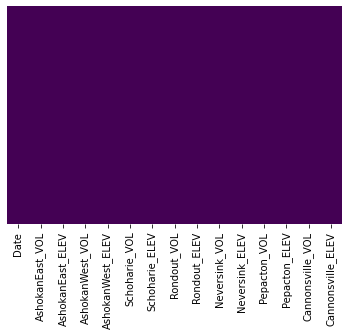

In [20]:
# Check for missing data
sns.heatmap(df_res.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [12]:
'''
***** ***** ***** ***** ***** ***** ***** ***** ***** *****
Reservoir Column Explanations:
***** ***** ***** ***** ***** ***** ***** ***** ***** *****
Date              - date measurements were taken
AshokanEast_VOL   - reservoir volume in billions of gallons
AshokanEast_ELEV  - reservoir water level in feet
AshokanWest_VOL   - reservoir volume in billions of gallons
AshokanWest_ELEV  - reservoir water level in feet
Schoharie_VOL     - reservoir volume in billions of gallons
Schoharie_ELEV    - reservoir water level in feet
Rondout_VOL       - reservoir volume in billions of gallons
Rondout_ELEV      - reservoir water level in feet
Neversink_VOL     - reservoir volume in billions of gallons
Neversink_ELEV    - reservoir water level in feet
Pepacton_VOL      - reservoir volume in billions of gallons
Pepacton_ELEV     - reservoir water level in feet
Cannonsville_VOL  - reservoir volume in billions of gallons
Cannonsville_ELEV - reservoir water level in feet
''';

## 2. Weather

#### Formatting

In [13]:
df_weather.columns

Index(['STATION', 'NAME', 'DATE', 'AWND', 'AWND_ATTRIBUTES', 'DAPR',
       'DAPR_ATTRIBUTES', 'EVAP', 'EVAP_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES',
       'PGTM', 'PGTM_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNOW',
       'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES',
       'TMIN', 'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WDF2',
       'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES',
       'WESF', 'WESF_ATTRIBUTES', 'WSF2', 'WSF2_ATTRIBUTES', 'WSF5',
       'WSF5_ATTRIBUTES', 'WT01', 'WT01_ATTRIBUTES', 'WT02', 'WT02_ATTRIBUTES',
       'WT03', 'WT03_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES', 'WT05',
       'WT05_ATTRIBUTES', 'WT06', 'WT06_ATTRIBUTES', 'WT08', 'WT08_ATTRIBUTES',
       'WT11', 'WT11_ATTRIBUTES'],
      dtype='object')

In [14]:
# Drop all nonrelevant columns except LOCATION/COUNTY, DATE, EVAP, WESF, PRCP, TMAX, TOBS, AWND, TMIN
df_weather.drop(['AWND_ATTRIBUTES', 'DAPR', 'DAPR_ATTRIBUTES', 'EVAP_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES',
                'PGTM', 'PGTM_ATTRIBUTES', 'PRCP_ATTRIBUTES', 'SNOW_ATTRIBUTES', 'SNWD_ATTRIBUTES',
                'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WDF2', 'WDF2_ATTRIBUTES',
                'WDF5', 'WDF5_ATTRIBUTES', 'WESD_ATTRIBUTES', 'WESF_ATTRIBUTES', 'WSF2_ATTRIBUTES', 'WSF5_ATTRIBUTES',
                'WT01', 'WT01_ATTRIBUTES', 'WT02', 'WT02_ATTRIBUTES', 'WT03', 'WT03_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES',
                'WT05', 'WT05_ATTRIBUTES', 'WT06', 'WT06_ATTRIBUTES', 'WT08', 'WT08_ATTRIBUTES', 'WT11', 'WT11_ATTRIBUTES'], axis=1, inplace=True)

In [15]:
df_weather.columns

Index(['STATION', 'NAME', 'DATE', 'AWND', 'EVAP', 'PRCP', 'SNOW', 'SNWD',
       'TMAX', 'TMIN', 'WESD', 'WESF', 'WSF2', 'WSF5'],
      dtype='object')

In [16]:
df_weather.shape

(54742, 14)

In [17]:
df_weather.rename(columns = {'STATION':'Weather_Station_ID', 'NAME':'Station_Name', 'DATE':'Date',
                             'AWND':'Wind_AVG', 'WSF5':'Wind_Max_5sec','EVAP':'Evaporation', 
                             'PRCP':'Precipitation', 'SNOW':'SnowFall', 'SNWD':'SnowDepth', 
                             'TMAX':'Temp_Hi', 'TMIN':'Temp_Low', 'WESD':'Water_Equiv_SnowDepth', 'WESF':'Water_Equiv_SnowFall', 'WSF2':'Wind_Max_2sec'}, inplace=True)

In [18]:
# New column order
cols = ['Weather_Station_ID', 'Station_Name', 'Date',  
        'Precipitation', 'SnowFall', 'SnowDepth', 'Water_Equiv_SnowFall', 'Water_Equiv_SnowDepth', 
        'Temp_Hi', 'Temp_Low', 'Evaporation', 'Wind_AVG','Wind_Max_2sec', 'Wind_Max_5sec']

# Reorder df columns
df_weather = df_weather[cols]

#### Dealing with missing data

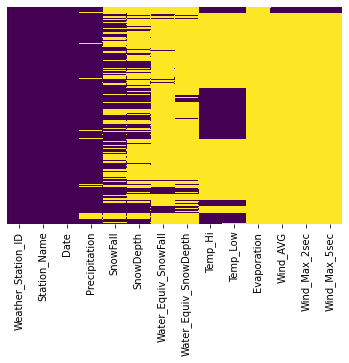

In [ ]:
# Check for missing data
sns.heatmap(df_weather.isnull(), yticklabels=False, cbar=False, cmap='viridis');
# WOW!

In [ ]:
# Due to missing data, we must drop these columns
df_weather.drop(['Evaporation', 'Wind_AVG', 'Wind_Max_2sec', 'Wind_Max_5sec'], axis=1, inplace=True)

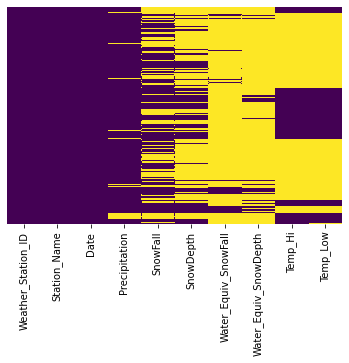

In [27]:
sns.heatmap(df_weather.isnull(), yticklabels=False, cbar=False, cmap='viridis');
# From the heatmap, we can see a lot of missing data. This isn't the worst as some of these features indicate precipitation on a given day.
# As we know, it doesn't rain everyday.
# However, we're still missing too much to make use of this data.

In [28]:
# Instead, let's use complete data from a weather station that is relatively close to all the reservoirs, instead of looking at micro-climates.

# With more than 1800 rows, we can assume data was sampled most days over the 5 years.
df_weather['Station_Name'].value_counts().loc[lambda x: x>1800]
# Looking at a map, the Callicoon Center station is relatively equidistant between both main reservoir areas.

EAST SIDNEY, NY US         1820
DELHI 6.6 WNW, NY US       1812
HOBART 4.8 ESE, NY US      1807
CALLICOON CENTER, NY US    1802
Name: Station_Name, dtype: int64

In [29]:
# Filter out all weather stations other than Callicoon Center
df_avg_weather = df_weather[df_weather['Station_Name'] == 'CALLICOON CENTER, NY US']

#### Let's check to see if this eliminated our missing data problem

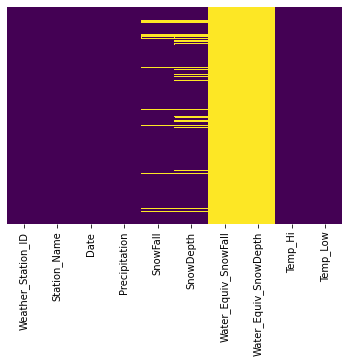

In [30]:
sns.heatmap(df_avg_weather.isnull(), yticklabels=False, cbar=False, cmap='viridis');
# Clearly, we can't use the 2 features which measured snow as its ground water equivalent. 

In [ ]:
# We'll have to drop those, too
df_avg_weather.drop(['Water_Equiv_SnowFall', 'Water_Equiv_SnowDepth'], axis=1, inplace=True)

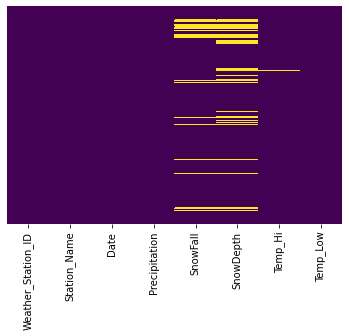

In [32]:
# Finally, we have enough data to proceed
sns.heatmap(df_avg_weather.isnull(), yticklabels=False, cbar=False, cmap='viridis');

#### Combine reservoir data and weather data

##### Make sure data columns are identical for later merge

In [ ]:
# Convert reservoir date column to pandas datetime formate
df_res['Date']          = pd.to_datetime(df_res['Date'])
df_avg_weather['Date']  = pd.to_datetime(df_avg_weather['Date'])

In [60]:
# Sort
df_res.sort_values(by='Date', inplace=True)
# After sorting, first date was actually before 2018

In [61]:
# Filter out dates before Jan 1, 2018
df_res = df_res.loc[df_res['Date'] >= '2018-01-01']

In [62]:
df_res.shape
# With this many rows, we know data was not collected on every single day (365 * 5) = 1,825 (+ at least 1 February 29)

(1796, 15)

In [ ]:
df_res.head(1)

,Date,AshokanEast_VOL,AshokanEast_ELEV,AshokanWest_VOL,AshokanWest_ELEV,Schoharie_VOL,Schoharie_ELEV,Rondout_VOL,Rondout_ELEV,Neversink_VOL,Neversink_ELEV,Pepacton_VOL,Pepacton_ELEV,Cannonsville_VOL,Cannonsville_ELEV
651,2018-01-01,59.94,574.0,32.67,574.33,13.1,1110.44,48.26,837.34,29.64,1427.56,111.39,1261.24,48.8,1113.87


In [ ]:
df_avg_weather.head(1)

,Weather_Station_ID,Station_Name,Date,Precipitation,SnowFall,SnowDepth,Temp_Hi,Temp_Low
20459,USC00301102,"CALLICOON CENTER, NY US",2018-01-01,0.0,0.0,5.0,5.0,-14.0


In [ ]:
# Used a merge (like a SQL left join on the reservoir dataframe since we had a weather dataframe with extra rows that wouldn't match up with anything)
reservoirs = pd.merge(df_res, df_avg_weather, how='left', on='Date')

In [ ]:
reservoirs.isnull().sum()

Date                    0
AshokanEast_VOL         0
AshokanEast_ELEV        0
AshokanWest_VOL         0
AshokanWest_ELEV        0
Schoharie_VOL           0
Schoharie_ELEV          0
Rondout_VOL             0
Rondout_ELEV            0
Neversink_VOL           0
Neversink_ELEV          0
Pepacton_VOL            0
Pepacton_ELEV           0
Cannonsville_VOL        0
Cannonsville_ELEV       0
Weather_Station_ID     24
Station_Name           24
Precipitation          25
SnowFall              166
SnowDepth             277
Temp_Hi                25
Temp_Low               24
dtype: int64

## Visualizations

In [69]:
df_res.head(1)

,Date,AshokanEast_VOL,AshokanEast_ELEV,AshokanWest_VOL,AshokanWest_ELEV,Schoharie_VOL,Schoharie_ELEV,Rondout_VOL,Rondout_ELEV,Neversink_VOL,Neversink_ELEV,Pepacton_VOL,Pepacton_ELEV,Cannonsville_VOL,Cannonsville_ELEV
651,2018-01-01,59.94,574.0,32.67,574.33,13.1,1110.44,48.26,837.34,29.64,1427.56,111.39,1261.24,48.8,1113.87


In [34]:
df_avg_weather.head(1)

,Weather_Station_ID,Station_Name,Date,Precipitation,SnowFall,SnowDepth,Temp_Hi,Temp_Low
20459,USC00301102,"CALLICOON CENTER, NY US",2018-01-01,0.0,0.0,5.0,5.0,-14.0


In [63]:
print(df_res.shape)
print(df_avg_weather.shape)

(1796, 15)
(1802, 8)


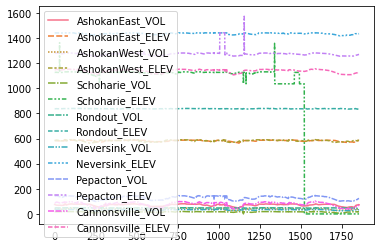

In [64]:
sns.lineplot(data=df_res);

#### Let's separate out Volume columns

In [37]:
df_res.columns

Index(['Date', 'AshokanEast_VOL', 'AshokanEast_ELEV', 'AshokanWest_VOL',
       'AshokanWest_ELEV', 'Schoharie_VOL', 'Schoharie_ELEV', 'Rondout_VOL',
       'Rondout_ELEV', 'Neversink_VOL', 'Neversink_ELEV', 'Pepacton_VOL',
       'Pepacton_ELEV', 'Cannonsville_VOL', 'Cannonsville_ELEV'],
      dtype='object')

In [65]:
res_elev = ['Date', 'AshokanEast_ELEV', 'AshokanWest_ELEV', 'Schoharie_ELEV', 'Rondout_ELEV','Neversink_ELEV', 'Pepacton_ELEV', 'Cannonsville_ELEV']
res_vol = ['Date', 'AshokanEast_VOL', 'AshokanWest_VOL', 'Schoharie_VOL', 'Rondout_VOL', 'Neversink_VOL', 'Pepacton_VOL', 'Cannonsville_VOL']

In [66]:
df_res_ELEV = df_res[res_elev]

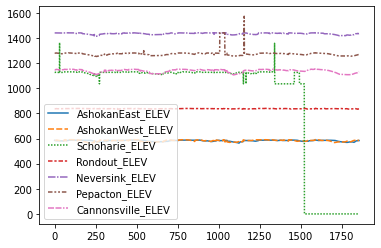

In [68]:
sns.lineplot(data=df_res_ELEV);

#### Convert dataframe to long form

In [70]:
# convert to long (tidy) form
dfm = df_res_ELEV.melt('Date', var_name='cols', value_name='vals')

In [73]:
# x_labels = []
# for y in ['18', '19', '20', '21', '22']:
#   for m in ['J', 'F', 'M', 'A', 'M', 'Jn', 'J', 'A', 'S', 'O', 'N', 'D']:
#     x_labels.append(m+y)


60

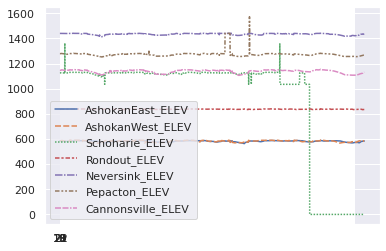

In [87]:
sns.set(style='darkgrid')
# g = sns.catplot(x="Date", y="vals", hue='cols', data=dfm, kind='point');
g = sns.lineplot(data=df_res_ELEV);
g.set_xticks(range(len(df_res_ELEV['Date'])))
g.set_xticklabels(['18', '19', '20', '21', '22']);